### SET UP AND VARIABLE DEFINITONS

In [61]:
## set up
import io
import requests
import pandas as pd
import numpy as np
from typing import Tuple
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, MultiTaskLassoCV
from sklearn import tree
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
import helper_functions.spreadsheet_specific_helpers as helper
import importlib
from collections import Counter
importlib.reload(helper)

<module 'helper_functions.spreadsheet_specific_helpers' from 'c:\\kelly\\School\\Colleage\\24-25\\seal\\gamification_data_analysis\\helper_functions\\spreadsheet_specific_helpers.py'>

In [2]:
SHEETURL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1XcR48HZuC-mSFB-uKIxwPFhfRGVX7bWy100PhcLA8oM/"
    "edit?resourcekey=&gid=1780925762#gid=1780925762"
)

# format for CSV https://docs.google.com/spreadsheets/d/
# <SHEET_ID>/gviz/tq?tqx=
# out:csv&sheet=<SHEET_NAME>
SHEET_CSV_URL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1XcR48HZuC-mSFB-uKIxwPFhfRGVX7bWy100PhcLA8oM/"
    "gviz/tq?tqx=out:csv&sheet=Congregated Data"
)

RANDOM_SEED = 12

In [159]:

# global variables for our current data purposes
Y_COLS = [
    "On a scale of 1 - 5 how successful do you feel you are in SEAL lab?",
    "On a scale of 1 - 5, how successful to do you feel your teammates are in SEAL lab?",
    "On a scale of 1 - 5, how successful do your peers think you are in SEAL lab?",
    "On whole, how would you rate your satisfaction in SEAL lab?"
]

X_DEMO_COLS = [
    "Main SEAL group affiliation",
    "Age",
    "Gender",
    "Sexual orientation",
    "Race",
    "Chronic condition",
    "Condition description",
    "Economic class",
    "Religion"
]

X_PERSONALITY_COLS = [
    "Internal / External game motivation",
    "[Introverted - Extroverted]",
    "[Critical - Trusting]",
    "[Spontaneous - Conscientious]",
    "[Self-conscious - Even-tempered]",
    "[Prefer similarity - Am open to change]"
]
MOTIVATION_COLS = [
    "Beating my competitors",
    "Mastering the game",
    "Earning the most points",
    "Working with a team",
    "Feeling immersed in the story/plot"
]

X_SEAL_COLS = [
    "I feel like I am playing a game",
    "I consider myself to be highly experienced.",
    "Aesthetically pleasing.",
    "Rank reflects work accurately.",
    "Leaderboard reflects work accurately.",
    "YBR reflects work accurately.",
    "VisTools reflects work accurately.",
    "RaceTrack reflects work accurately.",
    "Battle Station reflects work accurately.",
    "Command Center reflects work accurately.",
    "I understand what my SEAL statistics mean.",
    "I know exactly how my actions affect my lab statistics",
    "Using the Sudoku Sheet Tools helps me and my team stay on track.",
    "Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.",
    "Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable."
]
# AO:AX
X_USABILITY_COLS = [
    'I think that I would like to use this system frequently',
    'I found the system unnecessarily complex',
    'I thought the system was easy to use',
    'I think that I would need the support of a technical person to be able to use this system',
    'I found the various functions in this system were well integrated',
    'I thought there was too much inconsistency in this system',
    'I would imagine that most people would learn to use this system very quickly',
    'I found the system very cumbersome to use',
    'I felt very confident using the system',
    'I needed to learn a lot of things before I could get going with this system.',
    'SUS Overall Score', 'Learnability subscore', 'Usability subscore']

Y_COLS = ["Personal success",
          "Teammate success",
          "Peer success",
          "Satisfaction in SEAL"
]
#X_DROP_COLS = ['All SEAL group affiliations', 'Game motivation']
X_DROP_COLS = ['All SEAL group affiliations', 'Game motivation','Developed for SUDOKU Sheet Tools?']

### Extract the data

In [134]:
def get_data() -> DataFrame:  # idealy we dont want to us Any, but for now
    """function to get the data from the google sheet
    raises: HTTPError: if the request fails (meaning url wrong or no inter)

    @returns: @type(DataFrame): the data from the google sheet"""

    response = requests.get(SHEET_CSV_URL)
    response.raise_for_status()  # Raise error if request fails
    df: DataFrame = pd.read_csv(io.StringIO(response.text))
    return df

In [135]:
## ORIGINAL
data = get_data()
columns = data.columns
print(columns)
print(data.shape) # 81 x 50


Index(['Main SEAL group affiliation', 'All SEAL group affiliations',
       'Developed for SUDOKU Sheet Tools?', 'Age', 'Gender',
       'Sexual orientation', 'Race', 'Chronic condition',
       'Condition description', 'Economic class', 'Religion',
       'Game motivation', 'Internal / External game motivation',
       '[Introverted - Extroverted]', '[Critical - Trusting]',
       '[Spontaneous - Conscientious]', '[Self-conscious - Even-tempered]',
       '[Prefer similarity - Am open to change]',
       'I feel like I am playing a game',
       'I consider myself to be highly experienced.',
       'Aesthetically pleasing.', 'Rank reflects work accurately.',
       'Leaderboard reflects work accurately.',
       'YBR reflects work accurately.', 'VisTools reflects work accurately.',
       'RaceTrack reflects work accurately.',
       'Battle Station reflects work accurately.',
       'Command Center reflects work accurately.',
       'I understand what my SEAL statistics mean.',
     

In [136]:
def split_xy(data) -> Tuple[DataFrame, DataFrame]:
    """function to split the x and y data into separate ndarrays based on
    a set of columns to be dropped

    @parameter: data @type(DataFrame): rawdata

    @returns: @type(ndarray): relevant x-values from data
    @returns: @type(ndarray): y-values from data"""
    
    split_col: DataFrame = helper.split_motivation_column(data)
    x_data = data.drop(columns=X_DROP_COLS + Y_COLS)    # split motivation columns
    x_data = pd.concat([x_data, split_col], axis=1)

    # handle X_SEAL_COLS: map disagree - agree as 1-5
    options_map = {'Strongly disagree': 1,
                    'Disagree': 2,
                    'Neutral': 3,
                    'Agree': 4,
                    'Strongly agree': 5
                    }
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)

    # Remove 'No response' features from demographic
    remove_vals = ['No response', 'Prefer not to answer','N/A']
    x_data[X_DEMO_COLS] = x_data[X_DEMO_COLS].replace(remove_vals, pd.NA)

    # Handle NaNs with data imputation of average
    x_data[X_PERSONALITY_COLS[1:]] = x_data[X_PERSONALITY_COLS[1:]].fillna(3)
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].fillna(3)
    x_data[X_USABILITY_COLS] = x_data[X_USABILITY_COLS].fillna(3)
    data[Y_COLS] = data[Y_COLS].fillna(3)

    # one-hot-encoding for categorical data (demographics, gaming)
    cat_col = x_data.select_dtypes(include=['object', 'category']).columns
    x_data = pd.get_dummies(x_data, columns = cat_col, drop_first=False)

    # filter low-frequency categories and remove non-contributing responses
    min_freq= 0.05 # 5% of data set
    freq = x_data.sum(axis=0) / len(x_data)
    filter_x = freq[freq > min_freq].index
    x_data = x_data[filter_x]
    regex = '|'.join(remove_vals)
    x_data = x_data.loc[:, ~x_data.columns.str.contains(regex, case=False, regex=True)]

    y_data = data[Y_COLS]
    return x_data, y_data

In [137]:
def standardize(x_train, x_test) -> Tuple[DataFrame, DataFrame]:
    """function that standardizes data to normal gaussian distribution.
    Standardization calculation is applied only to the training data.

    @parameter: x_train @type(nd.array) processed x training data to be standardized
    @paremeter: x_test @type(nd.array) processed x-test data to be standardized
    """
    scaler = StandardScaler().fit(x_train)  # only fit on training data
    x_train_stand = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test_stand = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train_stand, x_test_stand

In [138]:
def inspect_correlation(data, title):
    """Generates heat map of given data set after being split."""
    corr = data.corr()

    threshold = 0.7
    # get all features that are highly correlated\
    #mask = (corr_x.abs() < threshold)
    #mask = mask & ~np.eye(mask.shape[0], dtype=bool)

    column_names =  [col[:2] for col in corr.columns]
    if (len(column_names) < 6):
        plt.figure(figsize=(10, 8))
    else:
        plt.figure(figsize=(14, 12))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, annot_kws={"size": 12})
    plt.title(title, fontsize = 25)
    plt.tight_layout()
    plt.show()

def inspect_correlation_separate(x_data, y_data, title, x_label, y_label, x_ticks):
    corr_matrix = pd.DataFrame(index = x_data.columns, columns = y_data.columns)
    for x_col in x_data.columns:
        for y_col in y_data.columns:
            corr_matrix.loc[x_col, y_col] = x_data[x_col].corr(y_data[y_col])

    corr_matrix = corr_matrix.astype(float)
    plt.figure(figsize=(16,10))
    ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", vmin=-1, vmax=1, annot_kws={"size": 16})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if x_ticks:
        ax.set_yticklabels(x_ticks)
    plt.yticks(rotation=0)
    plt.title(title, fontsize = 20)
    plt.tight_layout()
    plt.show()
    return ax

In [139]:
def plot_multitask_lasso_path(x_train, y_train):
    lasso_cv = MultiTaskLassoCV(alphas=np.logspace(-4, 0, 100), cv=5, random_state=RANDOM_SEED)
    lasso_cv.fit(x_train, y_train)

    # lasso_cv.coef_ is shape (n_targets, n_features)
    # To plot, we show coefficient magnitudes across alphas for each target separately

    alphas = lasso_cv.alphas_
    n_targets = y_train.shape[1]

    for task_idx in range(n_targets):
        coefs = []
        for alpha in alphas:
            lasso = MultiTaskLassoCV(alphas=[alpha], cv=5, random_state=RANDOM_SEED)
            lasso.fit(x_train, y_train)
            coefs.append(lasso.coef_[task_idx])

        coefs = np.array(coefs)
        plt.figure(figsize=(10, 5))
        for i in range(coefs.shape[1]):
            plt.plot(np.log10(alphas), coefs[:, i], label=x_train.columns[i])

        plt.xlabel("log10(alpha)")
        plt.ylabel(f"Coefficients (Target {task_idx+1})")
        plt.title(f"LASSO Path for Target {task_idx+1}")
        plt.grid(True)
        plt.tight_layout()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.show()

In [140]:
def feature_selection(x_train, y_train):
    """function to apply LASSO regression on training data to select optimal
    features.

    @parameter: x_train @type(nd.array) standardized x_train data
    @parameter: y_train @type(nd.array) y_train data"""

    # perform 5-fold cross validation on lasso values
    lasso = MultiTaskLassoCV(alphas=np.logspace(-4, 0, 100), cv=5, random_state=RANDOM_SEED)
    lasso.fit(x_train, y_train)
    best_l1 = lasso.alpha_
    non_zero_indices = np.abs(lasso.coef_) >= 1e-8

    top_features = []
    eliminated_features = []

    for i, feature in enumerate(x_train.columns):
        if np.any(non_zero_indices[:, i]):
            top_features.append(feature)
        else:
            eliminated_features.append(feature)
    return x_train[top_features], best_l1, eliminated_features, top_features


In [141]:

def linear_regression(x_train, y_train, x_test, y_test):
    """function to perform linear regression and calculate train and validation rmse
    via cross validation

    @parameter: x_train @type(nd.array) processed x_train data
    @parameter: y_train @type(nd.array) y_train data
    @returns: models @type(nd.array) linear regression models
    @returns: val_rmse @type(nd.array) validation rmses"""
    models = []
    val_rmse = []
    train_rmse = []
    test_rmse = []

    x_train_const = sm.add_constant(x_train)
    x_test_const = sm.add_constant(x_test)
    for i in range(y_train.shape[1]):
        y_t = y_train.iloc[:,i]
        y_test_i = y_test.iloc[:,i]
        model = sm.OLS(y_t, x_train_const).fit()
        models.append(model)

        skmodel = LinearRegression()
        cv = KFold(n_splits = 5, shuffle=True, random_state = RANDOM_SEED)
        scores = cross_val_score(skmodel, x_train, y_t, cv=cv, scoring='neg_mean_squared_error')
        v_rmse = np.sqrt(-scores.mean())
        val_rmse.append(v_rmse)

        # training error
        y_train_pred = model.predict(x_train_const)
        t_rmse = np.sqrt(mean_squared_error(y_t, y_train_pred))
        train_rmse.append(t_rmse)

        #testing error
        y_test_pred = model.predict(x_test_const)
        test_score = np.sqrt(mean_squared_error(y_test_i, y_test_pred))
        test_rmse.append(test_score)
        
    linear_visualization(models, y_train.columns, train_rmse, val_rmse, test_rmse)
    return models, train_rmse, val_rmse, test_rmse

def linear_visualization(models, y_cols, train_rmse, val_rmse, test_rmse):
    """function to visualize weights of top k coefficients of list of models
    """

    top_positive = []
    top_negative = []
    for i, model in enumerate(models):
        print(Y_COLS[i])
        
        coef = model.params
        pvals = model.pvalues
        coef_df = pd.DataFrame({
            "Feature": coef.index,
            "Coef": coef.values,
            "Pval": pvals.values,
            "Abs": np.abs(coef.values)
        })
        coef_df = coef_df[coef_df["Feature"] != "const"]

        top = coef_df.nlargest(10, "Abs")
        
        print(top[["Feature","Coef", "Pval"]])

        top_pos = top[top["Coef"] > 0]["Feature"].tolist()
        top_neg = top[top["Coef"] < 0]["Feature"].tolist()

        top_positive.extend(top_pos)
        top_negative.extend(top_neg)

        plt.figure(figsize = (10,5))
        plt.barh(top["Feature"], top["Coef"])
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{y_cols[i]}")
        plt.show()

    # separate model training and validation rmses
    x = np.arange(len(Y_COLS))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 8))
    bars1 = ax.bar(x - width, train_rmse, width, label='Train RMSE')
    bars2 = ax.bar(x, val_rmse, width, label='Validation RMSE')
    bars3 = ax.bar(x + width, test_rmse, width, label='Test RMSE')

    ax.set_ylabel('RMSE')
    ax.set_title('Training vs Validation vs Test RMSE for Linear Regression')
    ax.set_xticks(x)
    ax.set_xticklabels(Y_COLS)
    ax.legend()

    for bar in bars1 + bars2 + bars3:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    positive_counts = Counter(top_positive)
    negative_counts = Counter(top_negative)
    print(positive_counts)
    print(negative_counts)

    


    

In [ ]:
# decision tree for individual parameters per tree
def decision_tree(x_train, y_train, x_test, y_test):
    """Function to classify success as decision tree"""
    best_models = []
    train_rmses = []
    test_rmses = []
    best_params = []

    parameters = {
    'max_depth': np.arange(2,10,1),
    'min_samples_leaf': [1,2,4,6],
    'min_samples_split': [2,5,7,10]
    }
    

    for i in range(y_train.shape[1]):
        y_tr = y_train.iloc[:,i]
        y_te = y_test.iloc[:,i]
        model = tree.DecisionTreeRegressor(random_state=RANDOM_SEED)
        grid = GridSearchCV(model, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
        grid.fit(x_train, y_tr)

        best_model = grid.best_estimator_
        best_param = grid.best_params_
        best_models.append(best_model)
        best_params.append(best_param)
 
        y_train_pred = best_model.predict(x_train)
        train_rmse = np.sqrt(mean_squared_error(y_train_pred,y_tr))
        train_rmses.append(train_rmse)
        y_test_pred = best_model.predict(x_test)
        test_rmse = np.sqrt(mean_squared_error(y_te, y_test_pred))
        test_rmses.append(test_rmse)

        print("Best parameters:", best_param)
    return best_models, train_rmses, test_rmses, best_params

def tree_visualize(models, features, y_vals, train_rmses, test_rmses):
    for i, model in enumerate(models):
        print(f"{Y_COLS[i]} trainRMSE: {train_rmses[i]:.2f} testRMSE: {test_rmses[i]:.2f}")
        print(f"Depth of tree for {y_vals[i]}: {model.get_depth()}")

        fig_width = 6 + model.get_depth() * 4  # Increase width more aggressively
        fig_height = 6 + len(features) * 0.2  # Avoid cramming vertically

        plt.figure(figsize=(fig_width, fig_height))

        tree.plot_tree(
            model,
            feature_names=features,
            filled=True,
            fontsize=10,
            proportion=False,  # True compresses too much for depth > 3
            rounded=True
        )

       # if model.get_depth() > 3:
        #    plt.figure(figsize=(22, 14)) 
       # else:  
         #   plt.figure(figsize=(12, 8))
        #tree.plot_tree(model, feature_names= features, filled = True, fontsize= 10,  proportion=False)
        plt.title(f"Decision tree for {y_vals[i]} [1-5]", fontsize=20)
        plt.tight_layout()
        
        plt.show()

In [160]:
print(data.shape)
x_data, y_data = split_xy(data)
print(x_data.shape)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state = RANDOM_SEED)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train, x_test = standardize(x_train, x_test)
x_features = x_train.columns
#y1, y2, y3, y4 = [y_data.iloc[:, i] for i in range(y_data.shape[1])]
print(x_train.shape)
x_nan = x_train.isna().sum().sum()
y_nan = x_train.isna().sum().sum()
print("NaN values", x_nan, y_nan)

x_train_reduced, l1, eliminated_features, top_features = feature_selection(x_train, y_train)
print(l1)
print(f'eliminated {len(eliminated_features)} {eliminated_features}')
print(f'kept {len(top_features)} {top_features}')
x_test_reduced = x_test[top_features]
print(x_train_reduced.shape)

(81, 50)
(81, 60)
(64, 60) (64, 4)
(17, 60) (17, 4)
(64, 60)
NaN values 0 0


C:\Users\kelly\AppData\Local\Temp\ipykernel_9644\305309105.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015102228708401999, tolerance: 0.015078431372549012
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015113745851710464, tolerance: 0.015078431372549012
  model = cd_fast.ene

0.20565123083486536
eliminated 44 ['[Introverted - Extroverted]', '[Critical - Trusting]', '[Spontaneous - Conscientious]', '[Prefer similarity - Am open to change]', 'I feel like I am playing a game', 'Aesthetically pleasing.', 'Rank reflects work accurately.', 'VisTools reflects work accurately.', 'Battle Station reflects work accurately.', 'Command Center reflects work accurately.', 'I understand what my SEAL statistics mean.', 'I know exactly how my actions affect my lab statistics', 'Using the Sudoku Sheet Tools helps me and my team stay on track.', 'Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable.', 'I found the system unnecessarily complex', 'I thought the system was easy to use', 'I think that I would need the support of a technical person to be able to use this system', 'I thought there was too much inconsistency in this system', 'I would imagine that most people would learn to use this system very quickly', 'I found the system very cumbersome to use', 'I nee

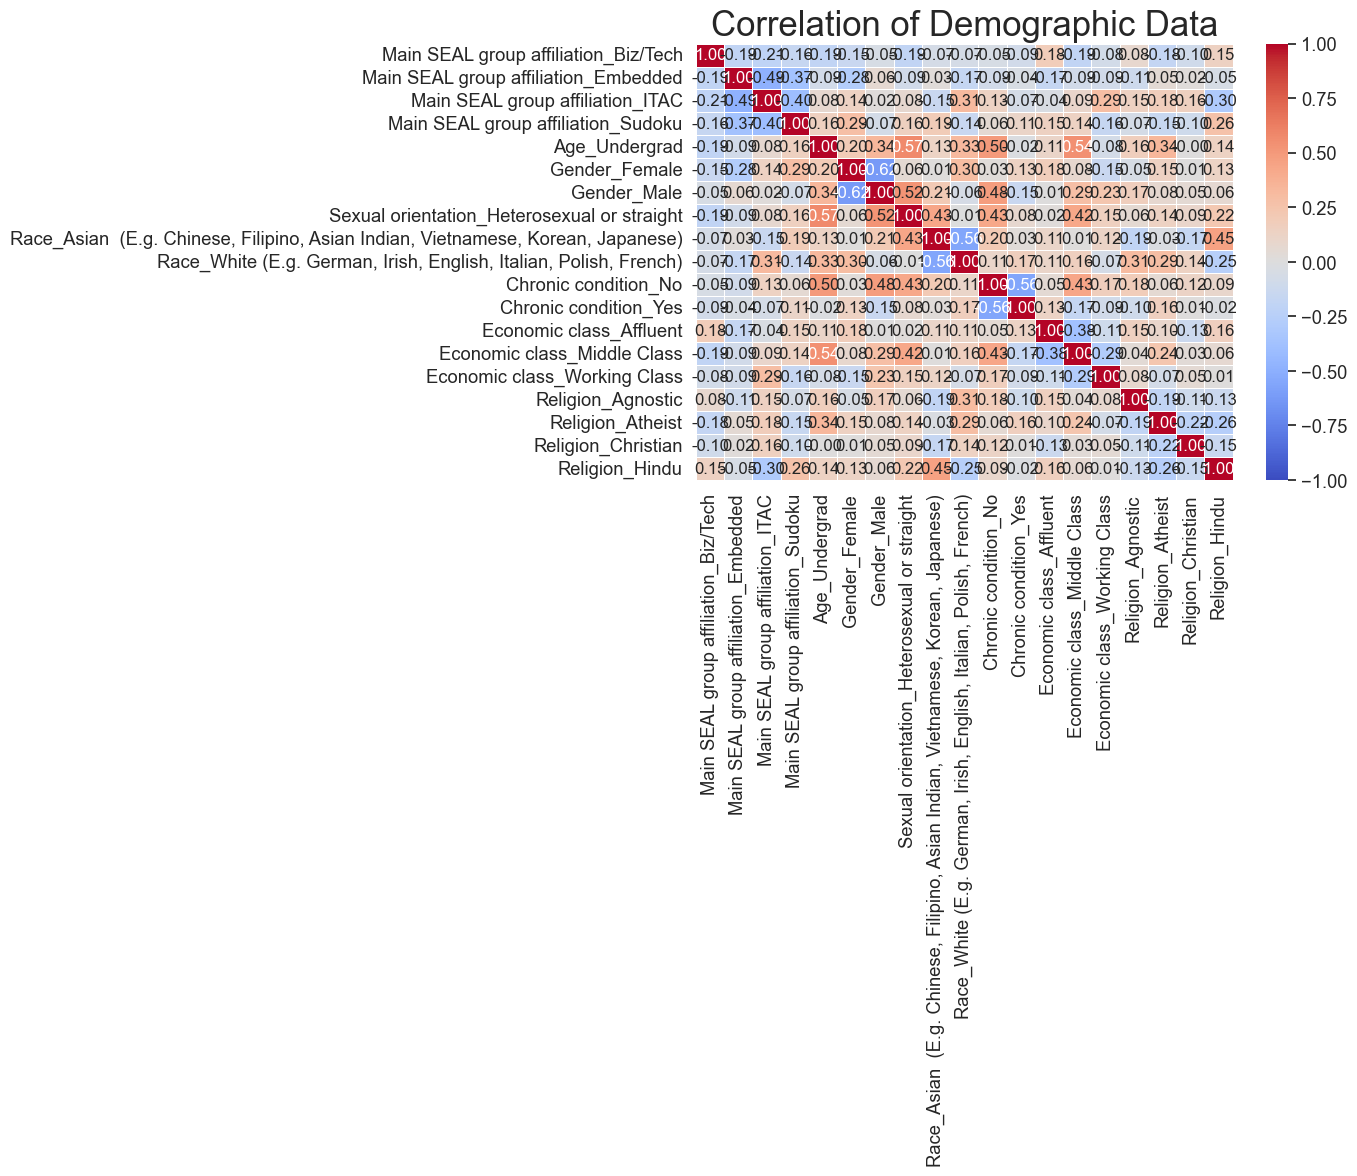

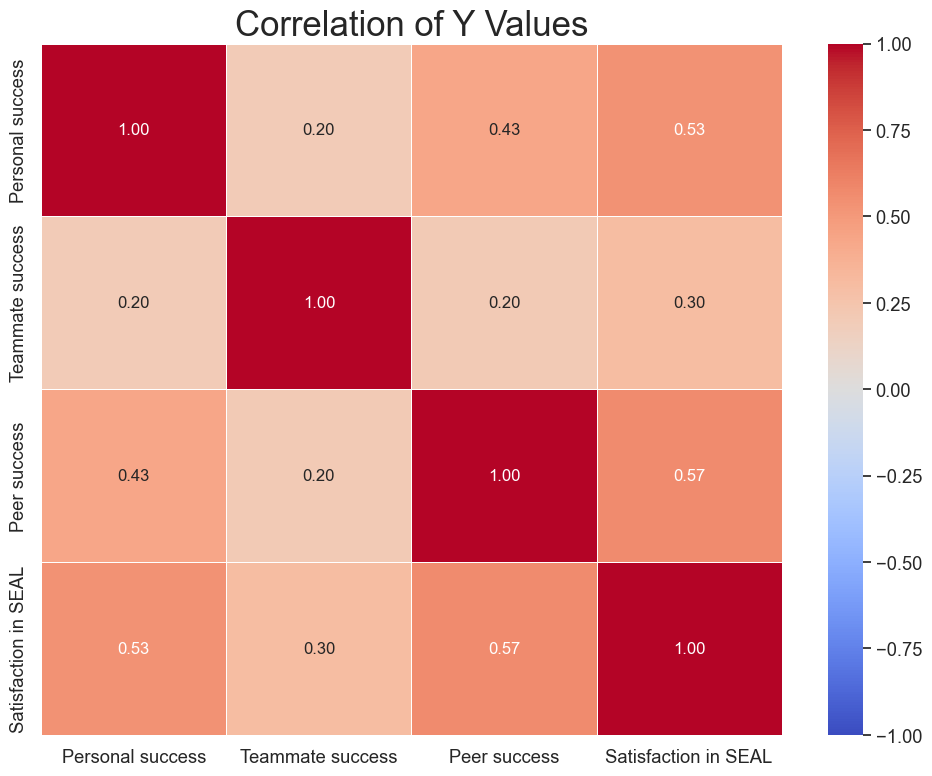

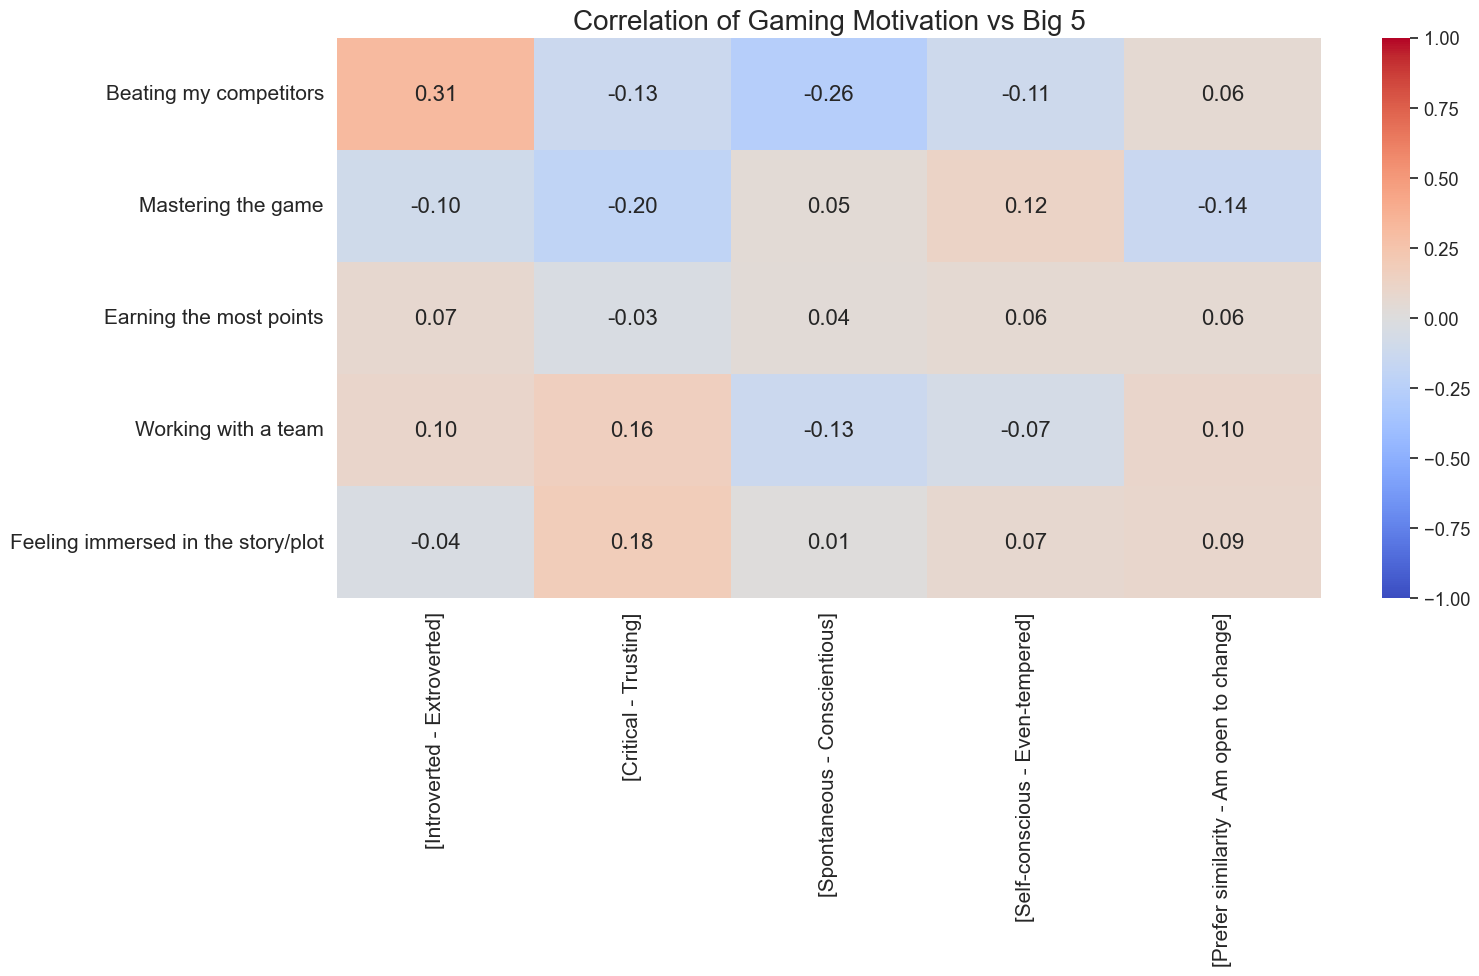

<Axes: title={'center': 'Correlation of Gaming Motivation vs Big 5'}>

In [149]:
# see data correlation
demo_processed = x_data.loc[:, x_data.columns.str.contains('|'.join(X_DEMO_COLS))]
motivation_processed = x_data.loc[:, x_data.columns.str.contains('|'.join(MOTIVATION_COLS))]
inspect_correlation(demo_processed.iloc[:,1:], "Correlation of Demographic Data")
inspect_correlation(y_data, "Correlation of Y Values")
inspect_correlation_separate(motivation_processed, x_data[X_PERSONALITY_COLS[1:]], "Correlation of Gaming Motivation vs Big 5","Personality", "Gaming Motivation", None)

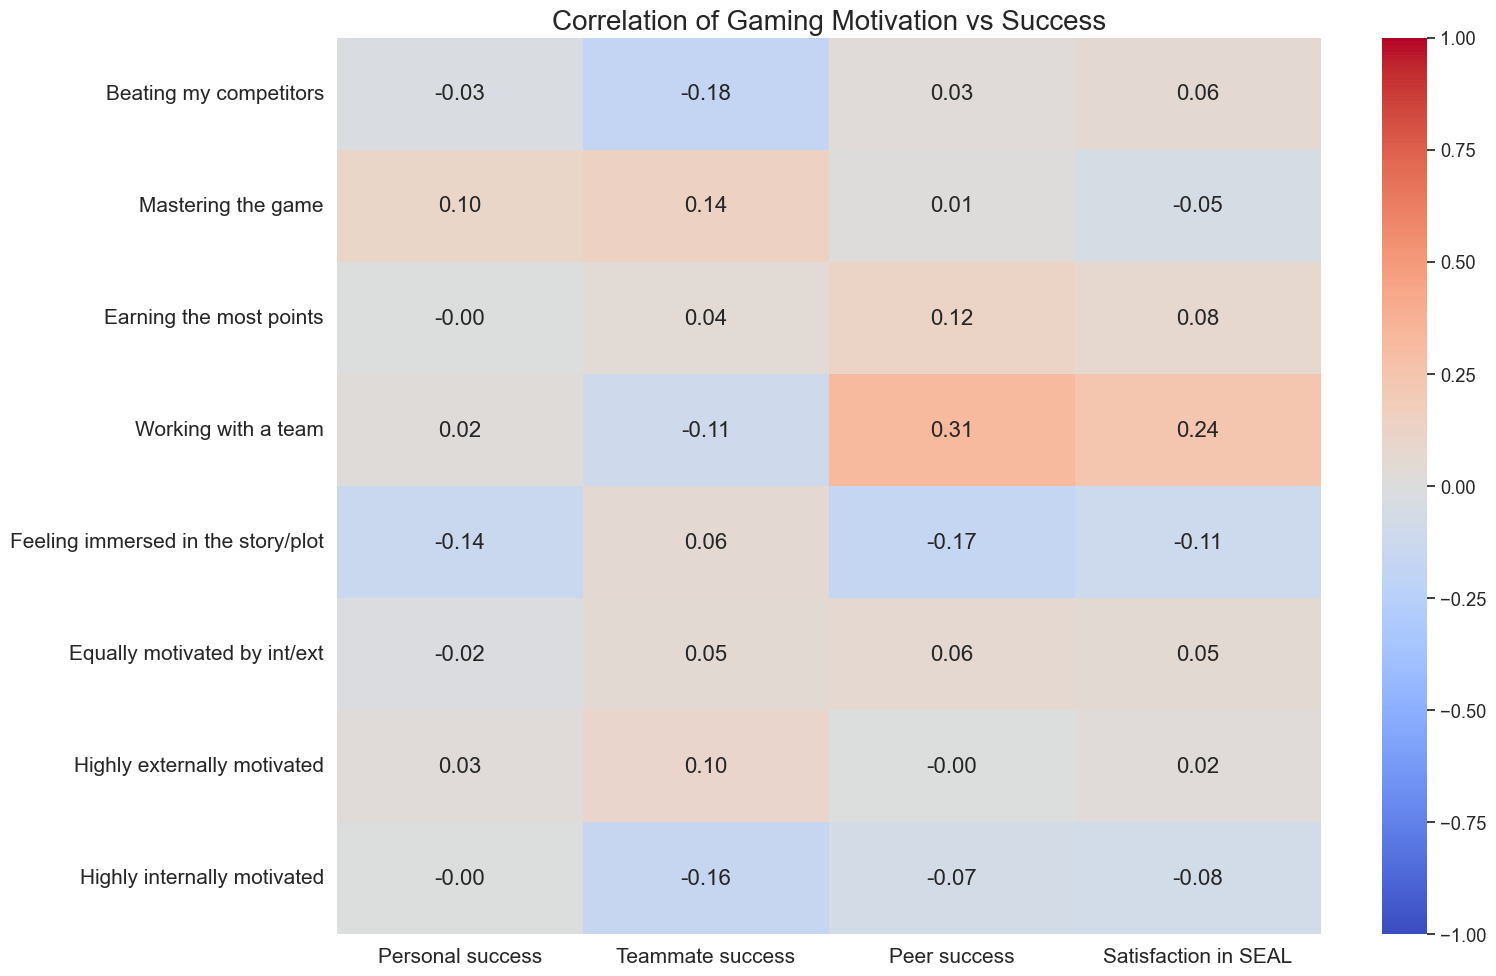

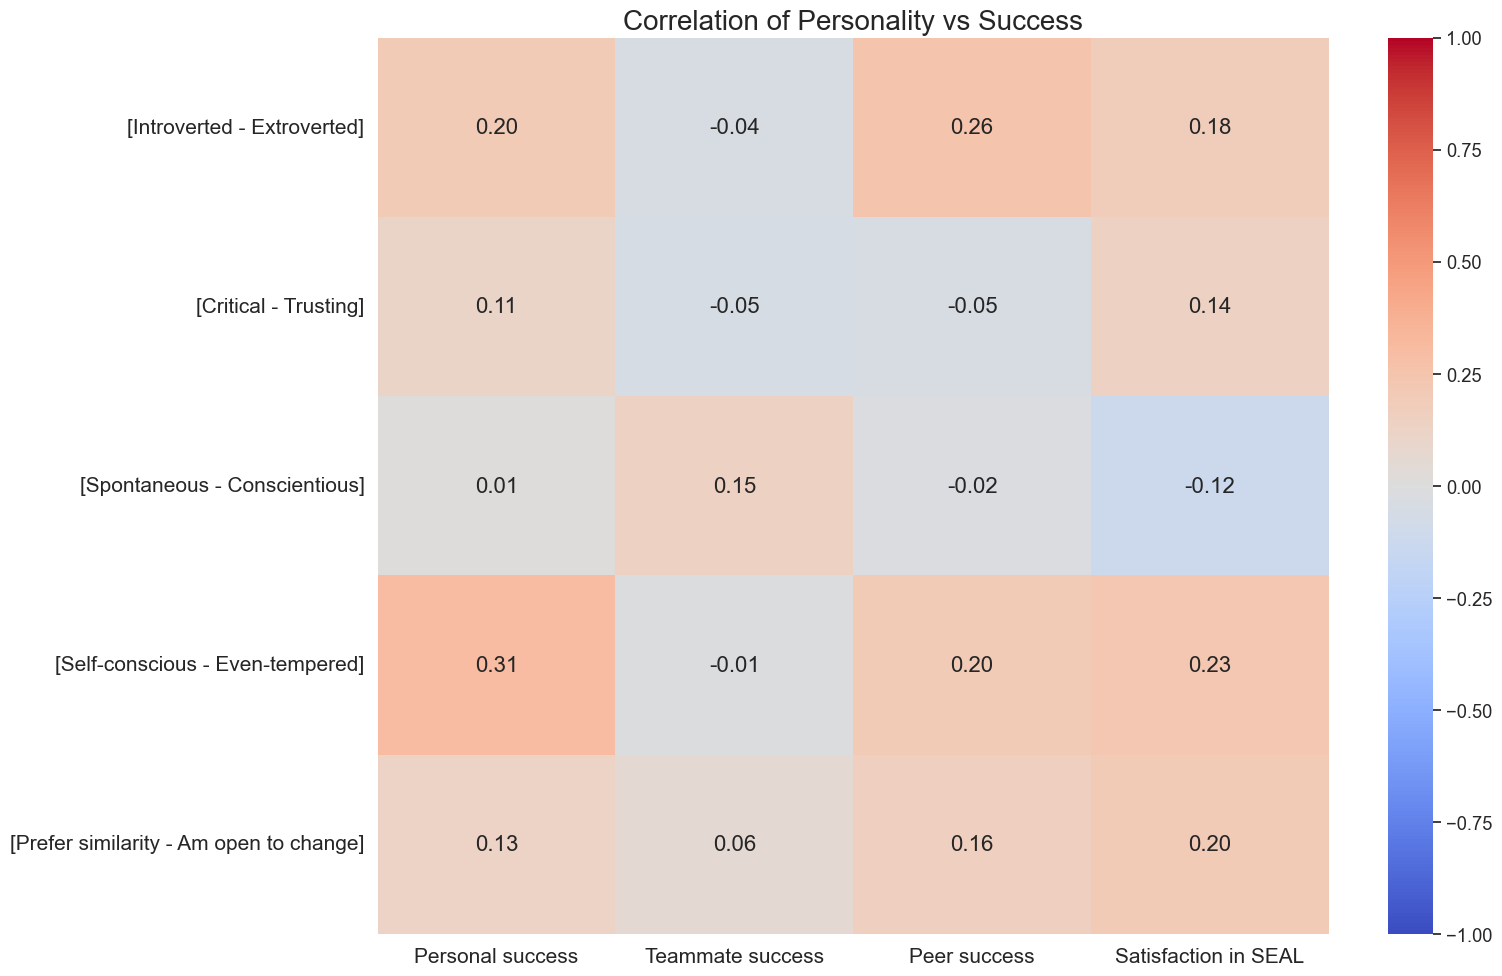

<Axes: title={'center': 'Correlation of Personality vs Success'}>

In [157]:
# see data correlation
search =  MOTIVATION_COLS + ["Internal / External game motivation"]
gaming_motivation = x_data.loc[:, x_data.columns.str.contains('|'.join(search))]
# full set gamer motivation vs y values
motivation_labels = ["Beating my competitors", "Mastering the game", "Earning the most points", "Working with a team",
                     "Feeling immersed in the story/plot", "Equally motivated by int/ext", "Highly externally motivated", "Highly internally motivated"]
inspect_correlation_separate(gaming_motivation, y_data, "Correlation of Gaming Motivation vs Success", "Success Values", "Gaming Motivation", motivation_labels)
# full set personality vs y values
personality = x_data[X_PERSONALITY_COLS[1:]]
inspect_correlation_separate( personality,y_data,"Correlation of Personality vs Success",  "Success Values", "Personality", None)

Personal success
                                              Feature      Coef      Pval
41                   Main SEAL group affiliation_ITAC  1.028042  0.399282
40               Main SEAL group affiliation_Embedded  0.877975  0.467670
44              Developed for SUDOKU Sheet Tools?_Yes  0.832619  0.186293
48        Sexual orientation_Heterosexual or straight -0.817684  0.418272
10              Leaderboard reflects work accurately.  0.777409  0.068062
38                 Feeling immersed in the story/plot -0.749927  0.108405
51                               Chronic condition_No  0.743816  0.240737
20  Using the Sudoku Sheet Tools makes my work in ...  0.735581  0.339603
52                              Chronic condition_Yes  0.732585  0.249231
9                      Rank reflects work accurately. -0.717206  0.204656


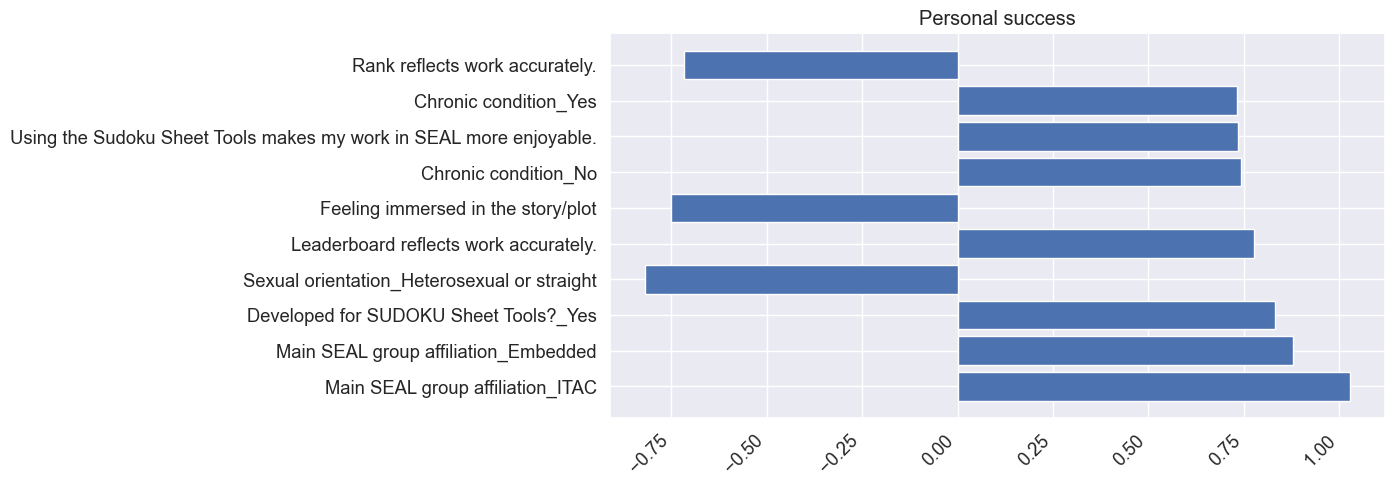

Teammate success
                                              Feature      Coef      Pval
49  Race_Asian  (E.g. Chinese, Filipino, Asian Ind... -1.888681  0.000840
50  Race_White (E.g. German, Irish, English, Itali... -1.279189  0.000075
52                              Chronic condition_Yes  1.278293  0.000394
8                             Aesthetically pleasing.  0.960304  0.001536
59                                     Religion_Hindu  0.858323  0.001119
20  Using the Sudoku Sheet Tools makes my work in ... -0.816538  0.007563
17  I know exactly how my actions affect my lab st... -0.801792  0.012086
25  I found the various functions in this system w...  0.786558  0.002748
44              Developed for SUDOKU Sheet Tools?_Yes  0.751344  0.003781
27  I would imagine that most people would learn t... -0.750378  0.006330


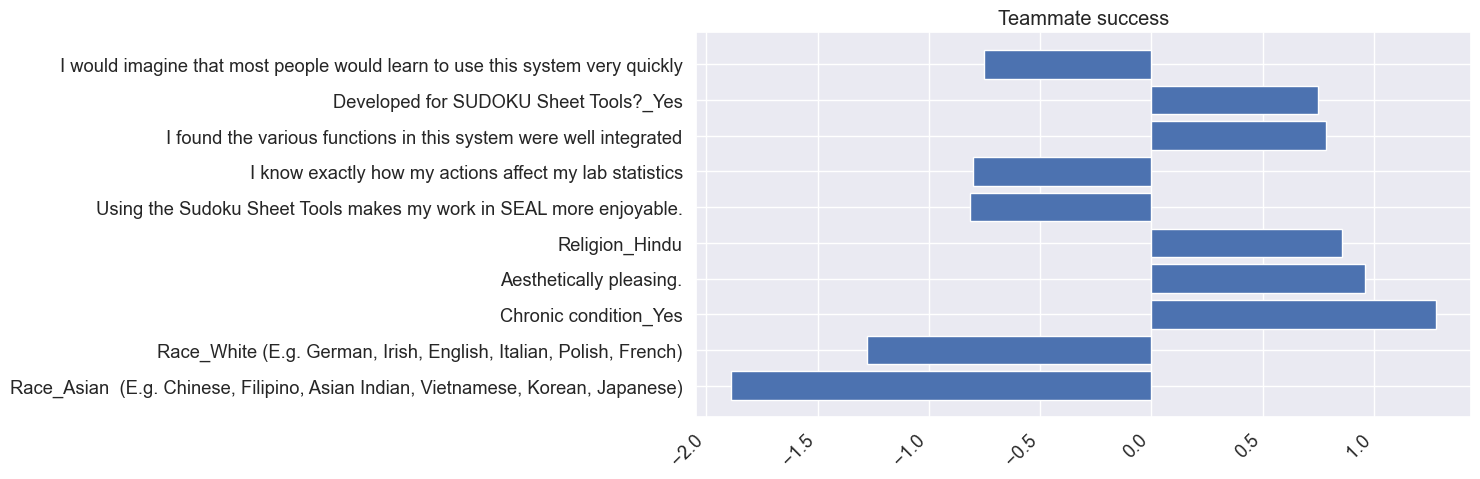

Peer success
                                              Feature      Coef      Pval
48        Sexual orientation_Heterosexual or straight -1.448494  0.033554
42                 Main SEAL group affiliation_Sudoku  0.915523  0.094156
36                            Earning the most points  0.862335  0.016220
26  I thought there was too much inconsistency in ...  0.845269  0.018920
40               Main SEAL group affiliation_Embedded  0.784042  0.248647
50  Race_White (E.g. German, Irish, English, Itali...  0.709987  0.020974
51                               Chronic condition_No  0.678232  0.073585
28          I found the system very cumbersome to use  0.654107  0.072589
3                       [Spontaneous - Conscientious]  0.629359  0.113393
52                              Chronic condition_Yes  0.607160  0.100681


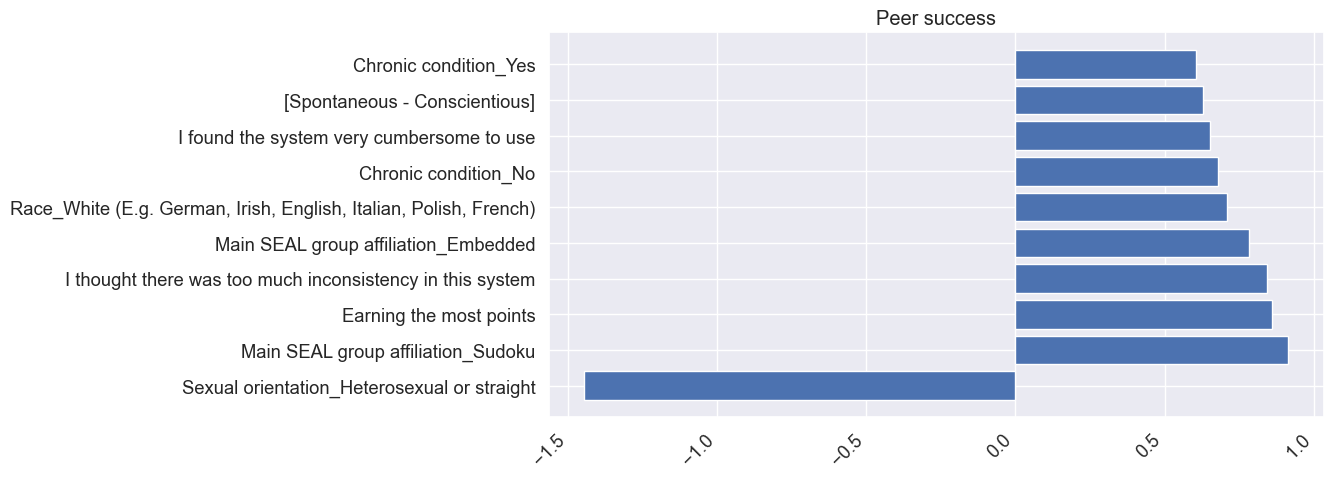

Satisfaction in SEAL
                                              Feature      Coef      Pval
49  Race_Asian  (E.g. Chinese, Filipino, Asian Ind...  1.021753  0.229574
17  I know exactly how my actions affect my lab st...  0.908305  0.183462
56                                  Religion_Agnostic  0.847940  0.063583
48        Sexual orientation_Heterosexual or straight -0.779830  0.321671
11                      YBR reflects work accurately.  0.764248  0.062280
44              Developed for SUDOKU Sheet Tools?_Yes -0.725264  0.141663
30  I needed to learn a lot of things before I cou...  0.719457  0.152263
7         I consider myself to be highly experienced.  0.712678  0.045038
28          I found the system very cumbersome to use  0.703479  0.147131
13                RaceTrack reflects work accurately. -0.641668  0.085127


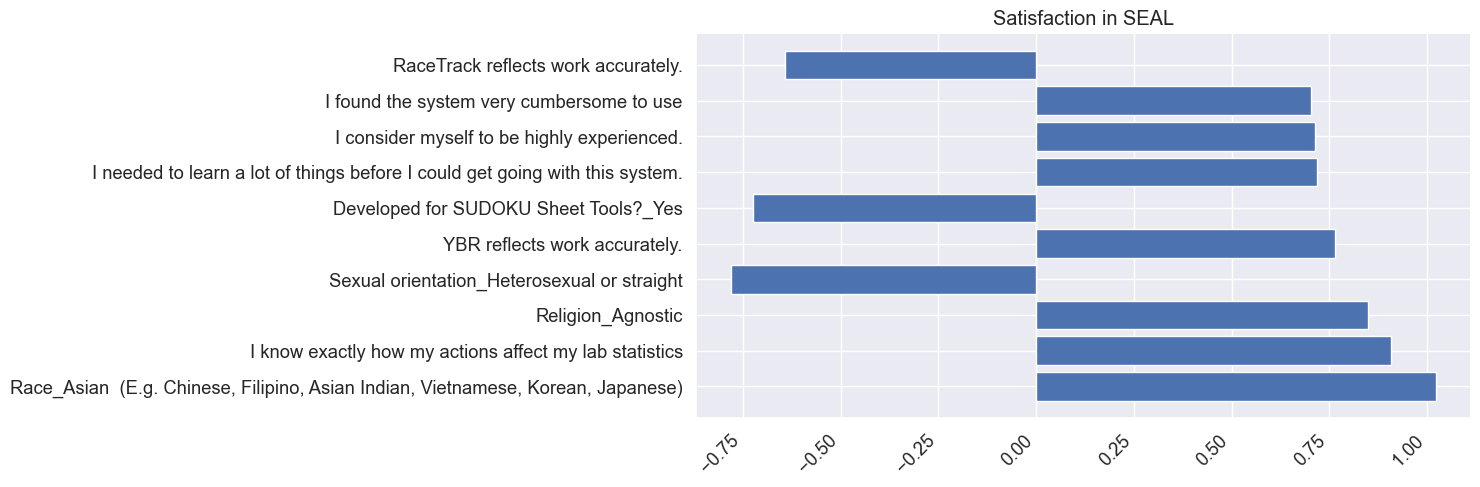

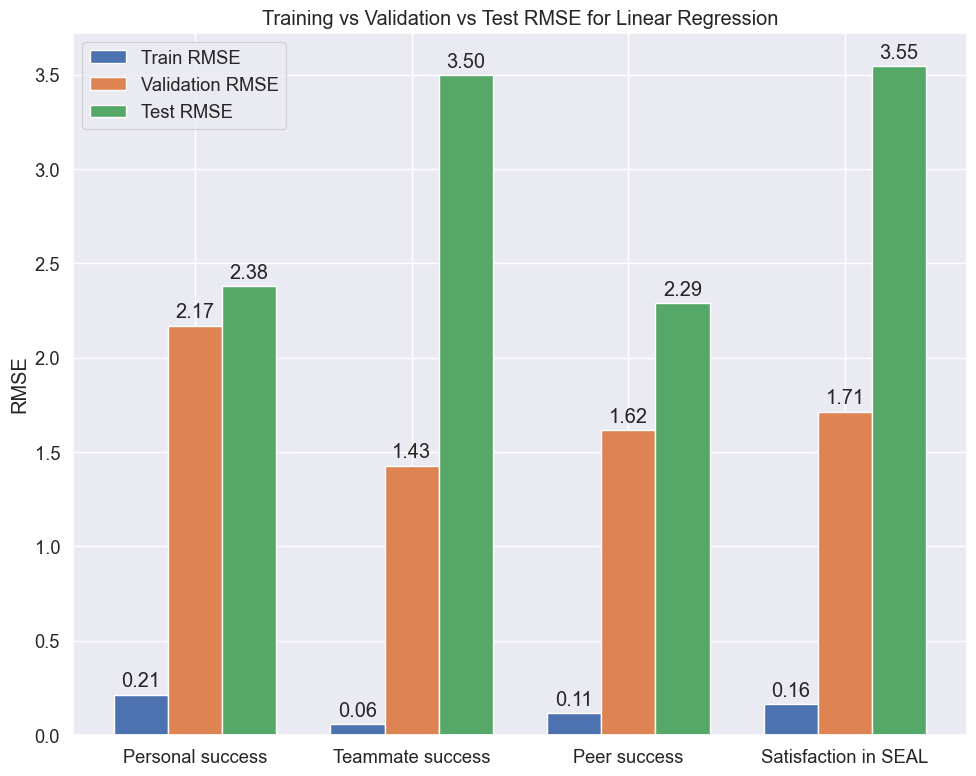

Counter({'Chronic condition_Yes': 3, 'Main SEAL group affiliation_Embedded': 2, 'Developed for SUDOKU Sheet Tools?_Yes': 2, 'Chronic condition_No': 2, 'I found the system very cumbersome to use': 2, 'Main SEAL group affiliation_ITAC': 1, 'Leaderboard reflects work accurately.': 1, 'Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable.': 1, 'Aesthetically pleasing.': 1, 'Religion_Hindu': 1, 'I found the various functions in this system were well integrated': 1, 'Main SEAL group affiliation_Sudoku': 1, 'Earning the most points': 1, 'I thought there was too much inconsistency in this system': 1, 'Race_White (E.g. German, Irish, English, Italian, Polish, French)': 1, '[Spontaneous - Conscientious]': 1, 'Race_Asian  (E.g. Chinese, Filipino, Asian Indian, Vietnamese, Korean, Japanese)': 1, 'I know exactly how my actions affect my lab statistics': 1, 'Religion_Agnostic': 1, 'YBR reflects work accurately.': 1, 'I needed to learn a lot of things before I could get going with this s

In [158]:
# linear models using different sets of data

models, train_rmse, val_rmse, test_rmse= linear_regression(x_train,y_train, x_test, y_test)



Personal success
                                              Feature      Coef      Pval
4                       YBR reflects work accurately.  0.324878  0.020312
2         I consider myself to be highly experienced.  0.322786  0.052781
1                    [Self-conscious - Even-tempered]  0.316105  0.003930
13                                        Gender_Male  0.200674  0.063083
5                 RaceTrack reflects work accurately. -0.176310  0.213004
11                   Main SEAL group affiliation_ITAC -0.133733  0.245184
3               Leaderboard reflects work accurately.  0.106292  0.451179
7   I think that I would like to use this system f...  0.076039  0.588193
10                                Working with a team -0.053590  0.601523
15                        Economic class_Middle Class -0.052329  0.619318


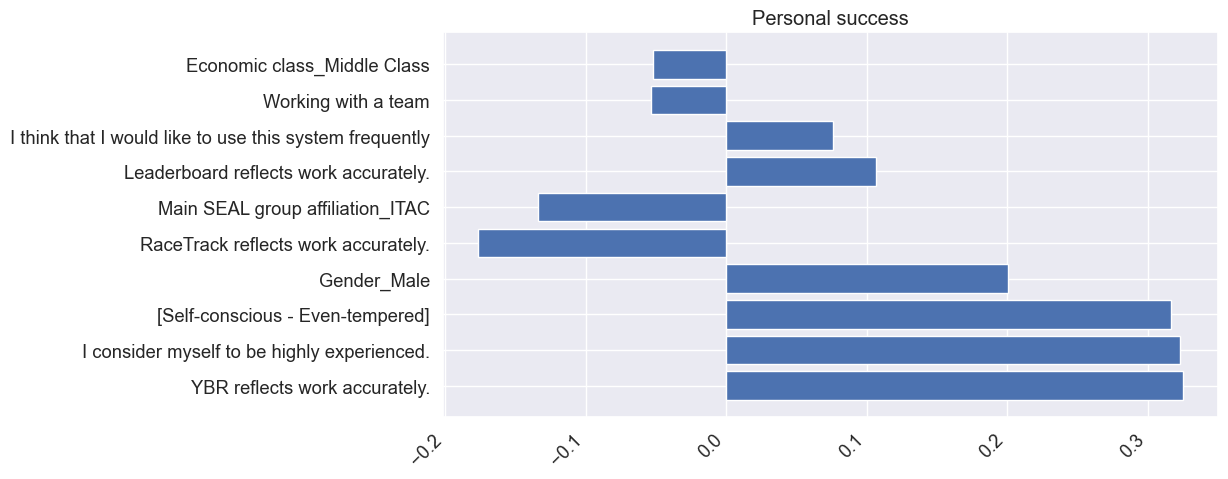

Teammate success
                                              Feature      Coef      Pval
14                              Chronic condition_Yes  0.296092  0.004706
4                       YBR reflects work accurately.  0.254212  0.051314
12                 Main SEAL group affiliation_Sudoku  0.235852  0.029708
16                                 Religion_Christian -0.206968  0.038570
9              I felt very confident using the system  0.198476  0.195908
8   I found the various functions in this system w...  0.154221  0.156359
1                    [Self-conscious - Even-tempered] -0.148261  0.136757
7   I think that I would like to use this system f... -0.124060  0.348751
15                        Economic class_Middle Class  0.101167  0.308840
13                                        Gender_Male  0.083199  0.405270


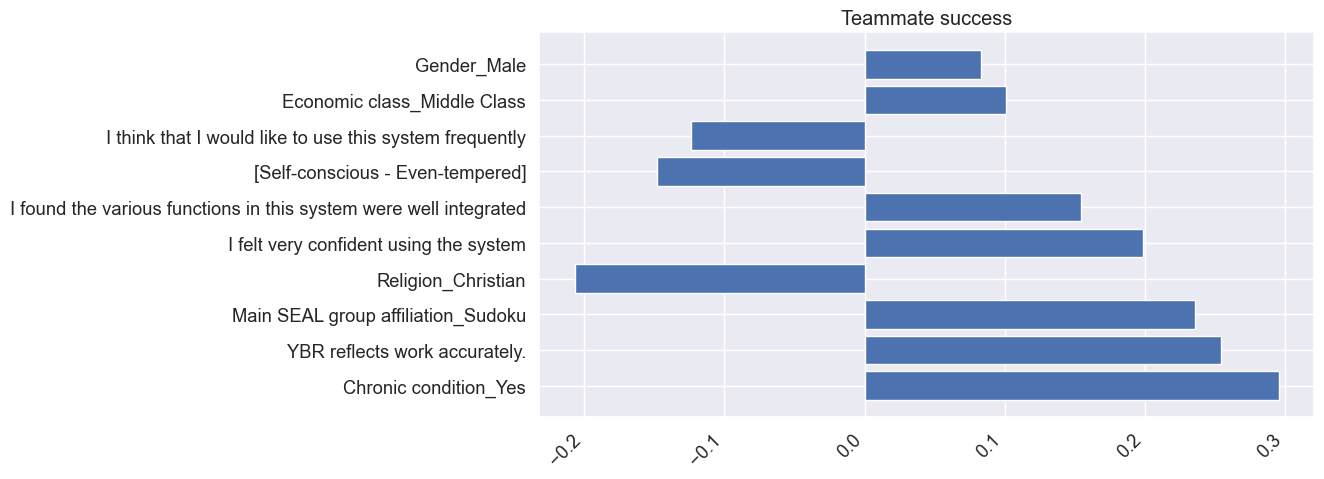

Peer success
                                        Feature      Coef      Pval
2   I consider myself to be highly experienced.  0.258582  0.083664
10                          Working with a team  0.219754  0.020713
5           RaceTrack reflects work accurately.  0.186498  0.144801
13                                  Gender_Male  0.138657  0.150796
9        I felt very confident using the system  0.126675  0.386674
11             Main SEAL group affiliation_ITAC -0.099379  0.336498
15                  Economic class_Middle Class  0.099085  0.298406
3         Leaderboard reflects work accurately.  0.097794  0.441533
16                           Religion_Christian -0.079169  0.399842
12           Main SEAL group affiliation_Sudoku -0.068957  0.497279


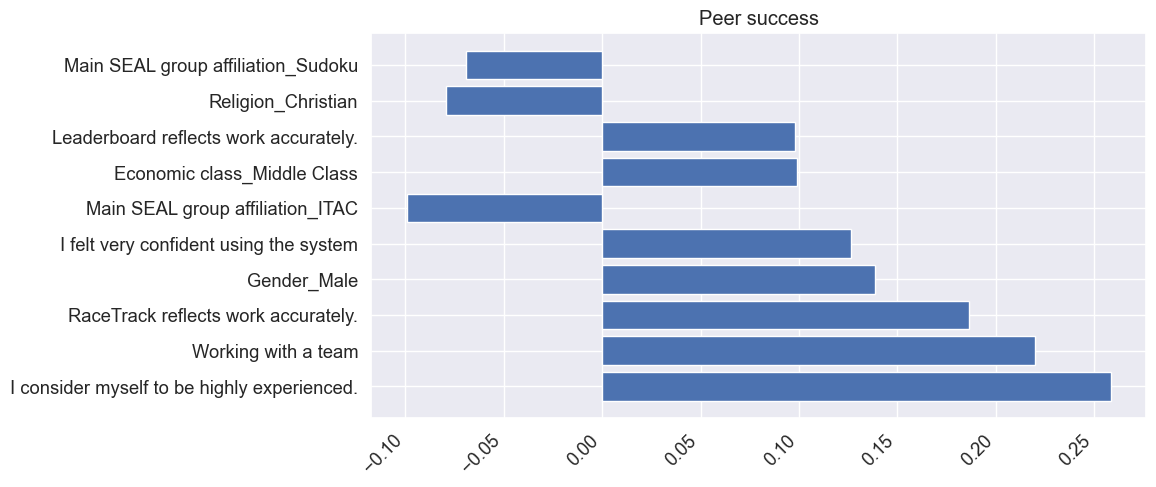

Satisfaction in SEAL
                                              Feature      Coef      Pval
2         I consider myself to be highly experienced.  0.330670  0.015475
4                       YBR reflects work accurately.  0.303023  0.008095
11                   Main SEAL group affiliation_ITAC -0.222610  0.019526
3               Leaderboard reflects work accurately.  0.155333  0.177005
12                 Main SEAL group affiliation_Sudoku -0.125837  0.171719
13                                        Gender_Male  0.122588  0.157748
1                    [Self-conscious - Even-tempered]  0.109837  0.199559
5                 RaceTrack reflects work accurately. -0.106418  0.351694
6   Using the Sudoku Sheet Tools encourages me to ...  0.104229  0.288779
10                                Working with a team  0.102573  0.220304


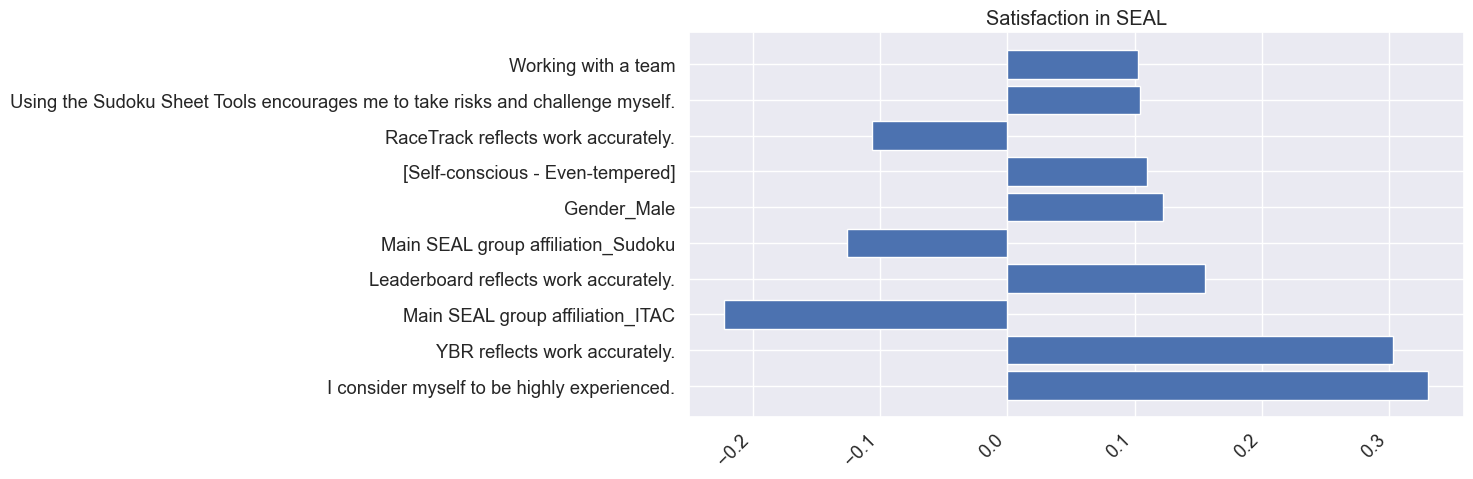

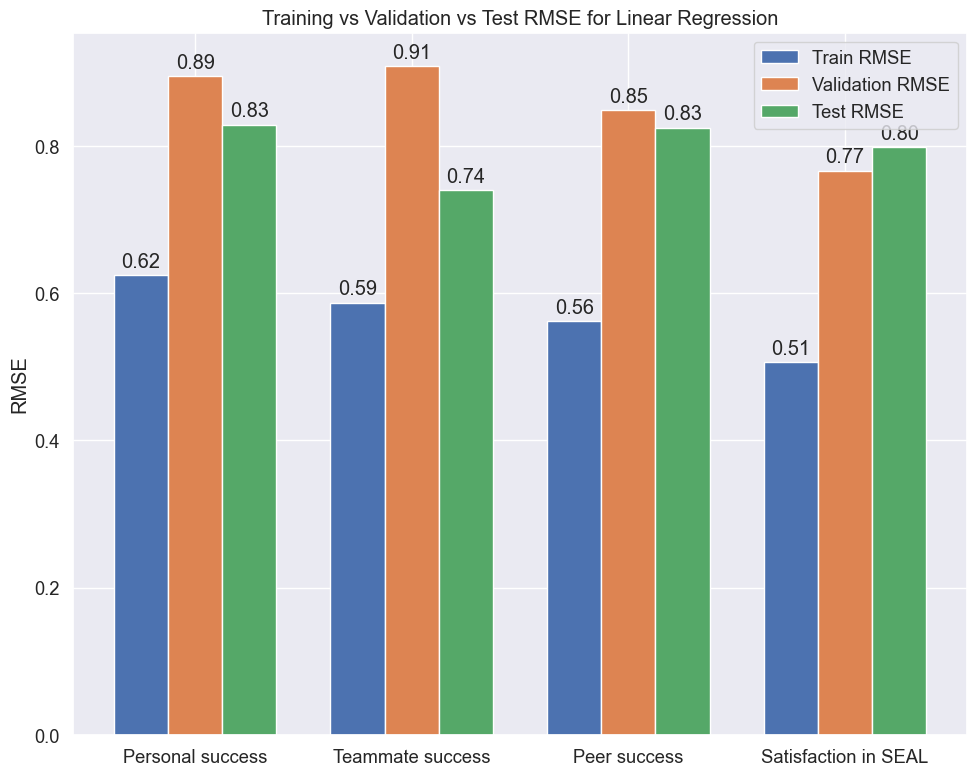

Counter({'Gender_Male': 4, 'YBR reflects work accurately.': 3, 'I consider myself to be highly experienced.': 3, 'Leaderboard reflects work accurately.': 3, '[Self-conscious - Even-tempered]': 2, 'I felt very confident using the system': 2, 'Economic class_Middle Class': 2, 'Working with a team': 2, 'I think that I would like to use this system frequently': 1, 'Chronic condition_Yes': 1, 'Main SEAL group affiliation_Sudoku': 1, 'I found the various functions in this system were well integrated': 1, 'RaceTrack reflects work accurately.': 1, 'Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.': 1})
Counter({'Main SEAL group affiliation_ITAC': 3, 'RaceTrack reflects work accurately.': 2, 'Religion_Christian': 2, 'Main SEAL group affiliation_Sudoku': 2, 'Working with a team': 1, 'Economic class_Middle Class': 1, '[Self-conscious - Even-tempered]': 1, 'I think that I would like to use this system frequently': 1})


In [161]:
# reduced 
models_r, train_rmse_r, val_rmse_r, test_rmse_r = linear_regression(x_train_reduced,y_train, x_test_reduced, y_test)

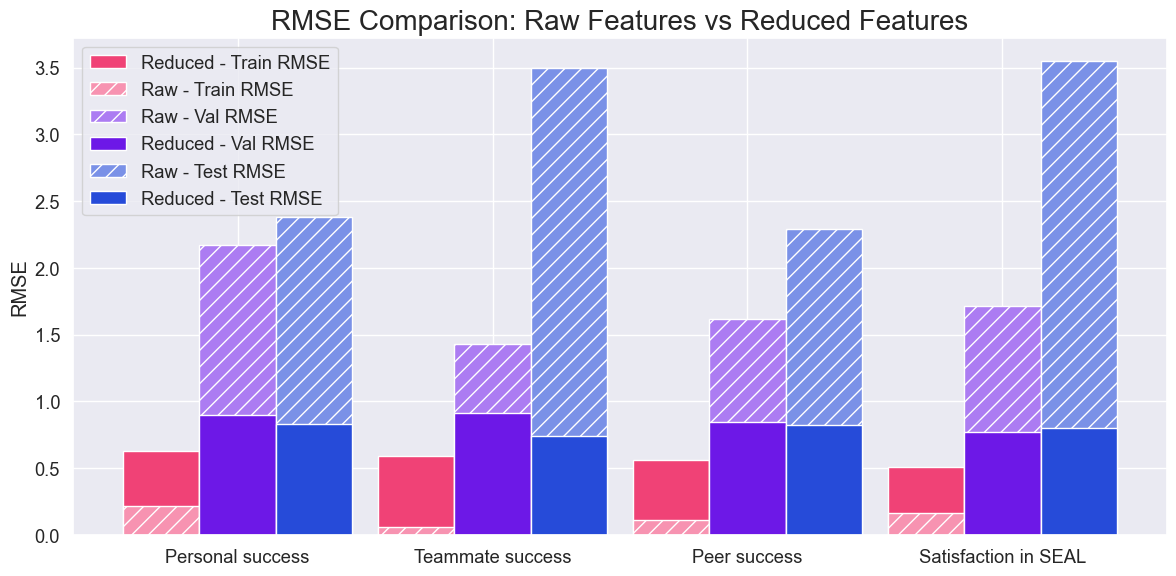

In [162]:
x = np.arange(len(Y_COLS)) 
width = 0.3

fig, ax = plt.subplots(figsize=(12, 6))

# Reduced model bars

ax.bar(x - width, train_rmse_r, width, label='Reduced - Train RMSE', color = '#F04276')
ax.bar(x - width, train_rmse, width, label='Raw - Train RMSE', color = "#F793B1", hatch = "//")
ax.bar(x + 0, val_rmse, width, label='Raw - Val RMSE', color='#AC7CF2',  hatch = "//")
ax.bar(x + 0, val_rmse_r, width, label='Reduced - Val RMSE', color = "#6D18E7")
ax.bar(x + width, test_rmse, width, label='Raw - Test RMSE', color = "#7A91E7",  hatch = "//")
ax.bar(x + width, test_rmse_r, width, label='Reduced - Test RMSE', color = "#264BD9")


ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison: Raw Features vs Reduced Features', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(Y_COLS, ha='center')
ax.legend()
plt.tight_layout()
plt.show()

Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters: {'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Personal success trainRMSE: 0.69 testRMSE: 0.78
Depth of tree for Personal success: 2


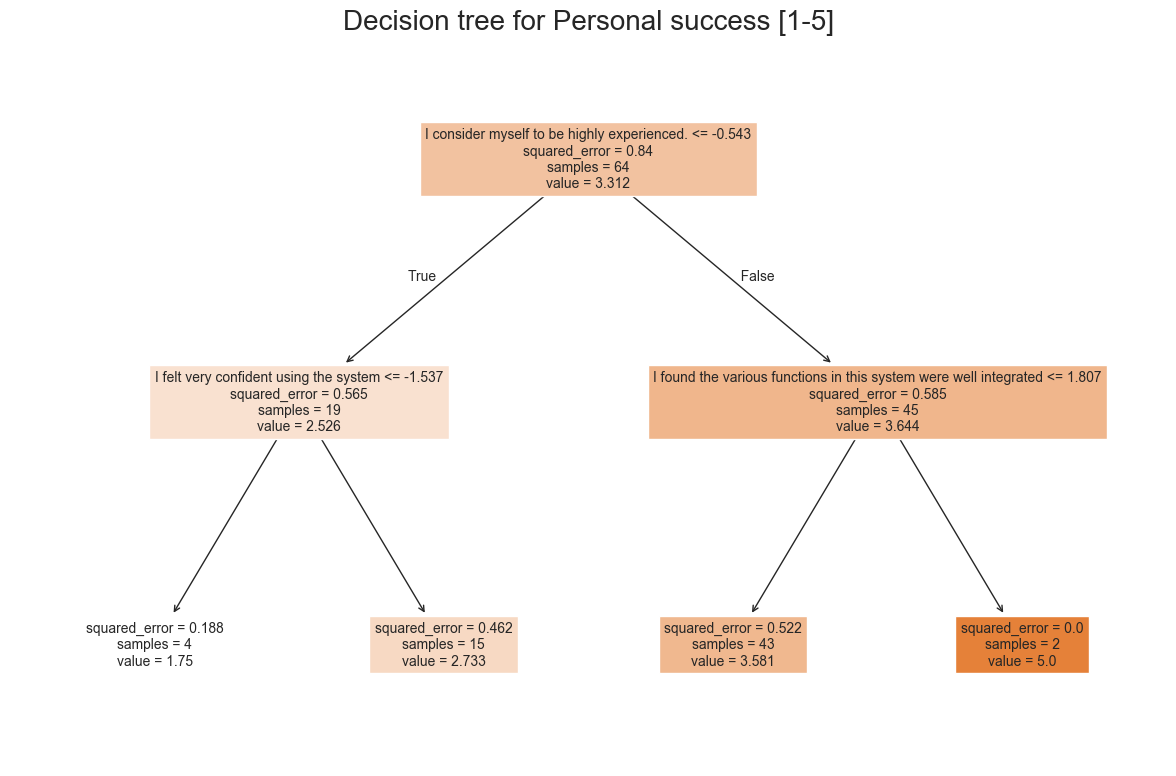

Teammate success trainRMSE: 0.67 testRMSE: 0.83
Depth of tree for Teammate success: 2


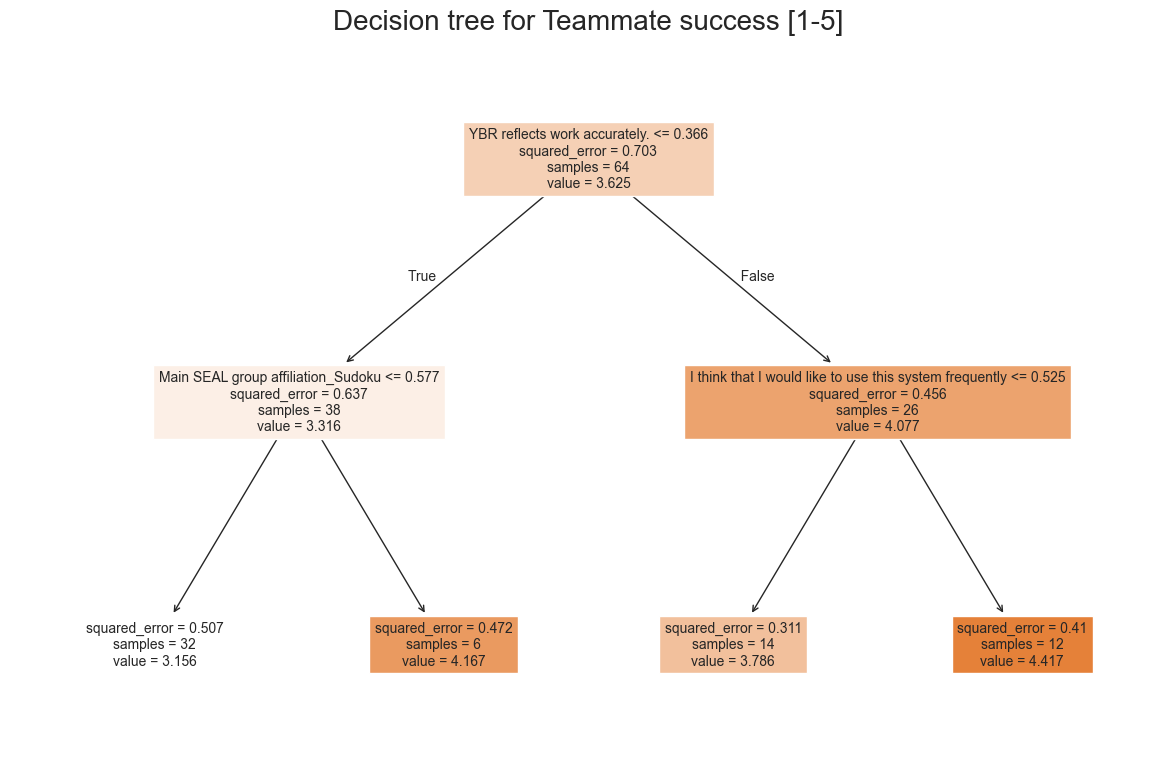

Peer success trainRMSE: 0.63 testRMSE: 0.98
Depth of tree for Peer success: 4


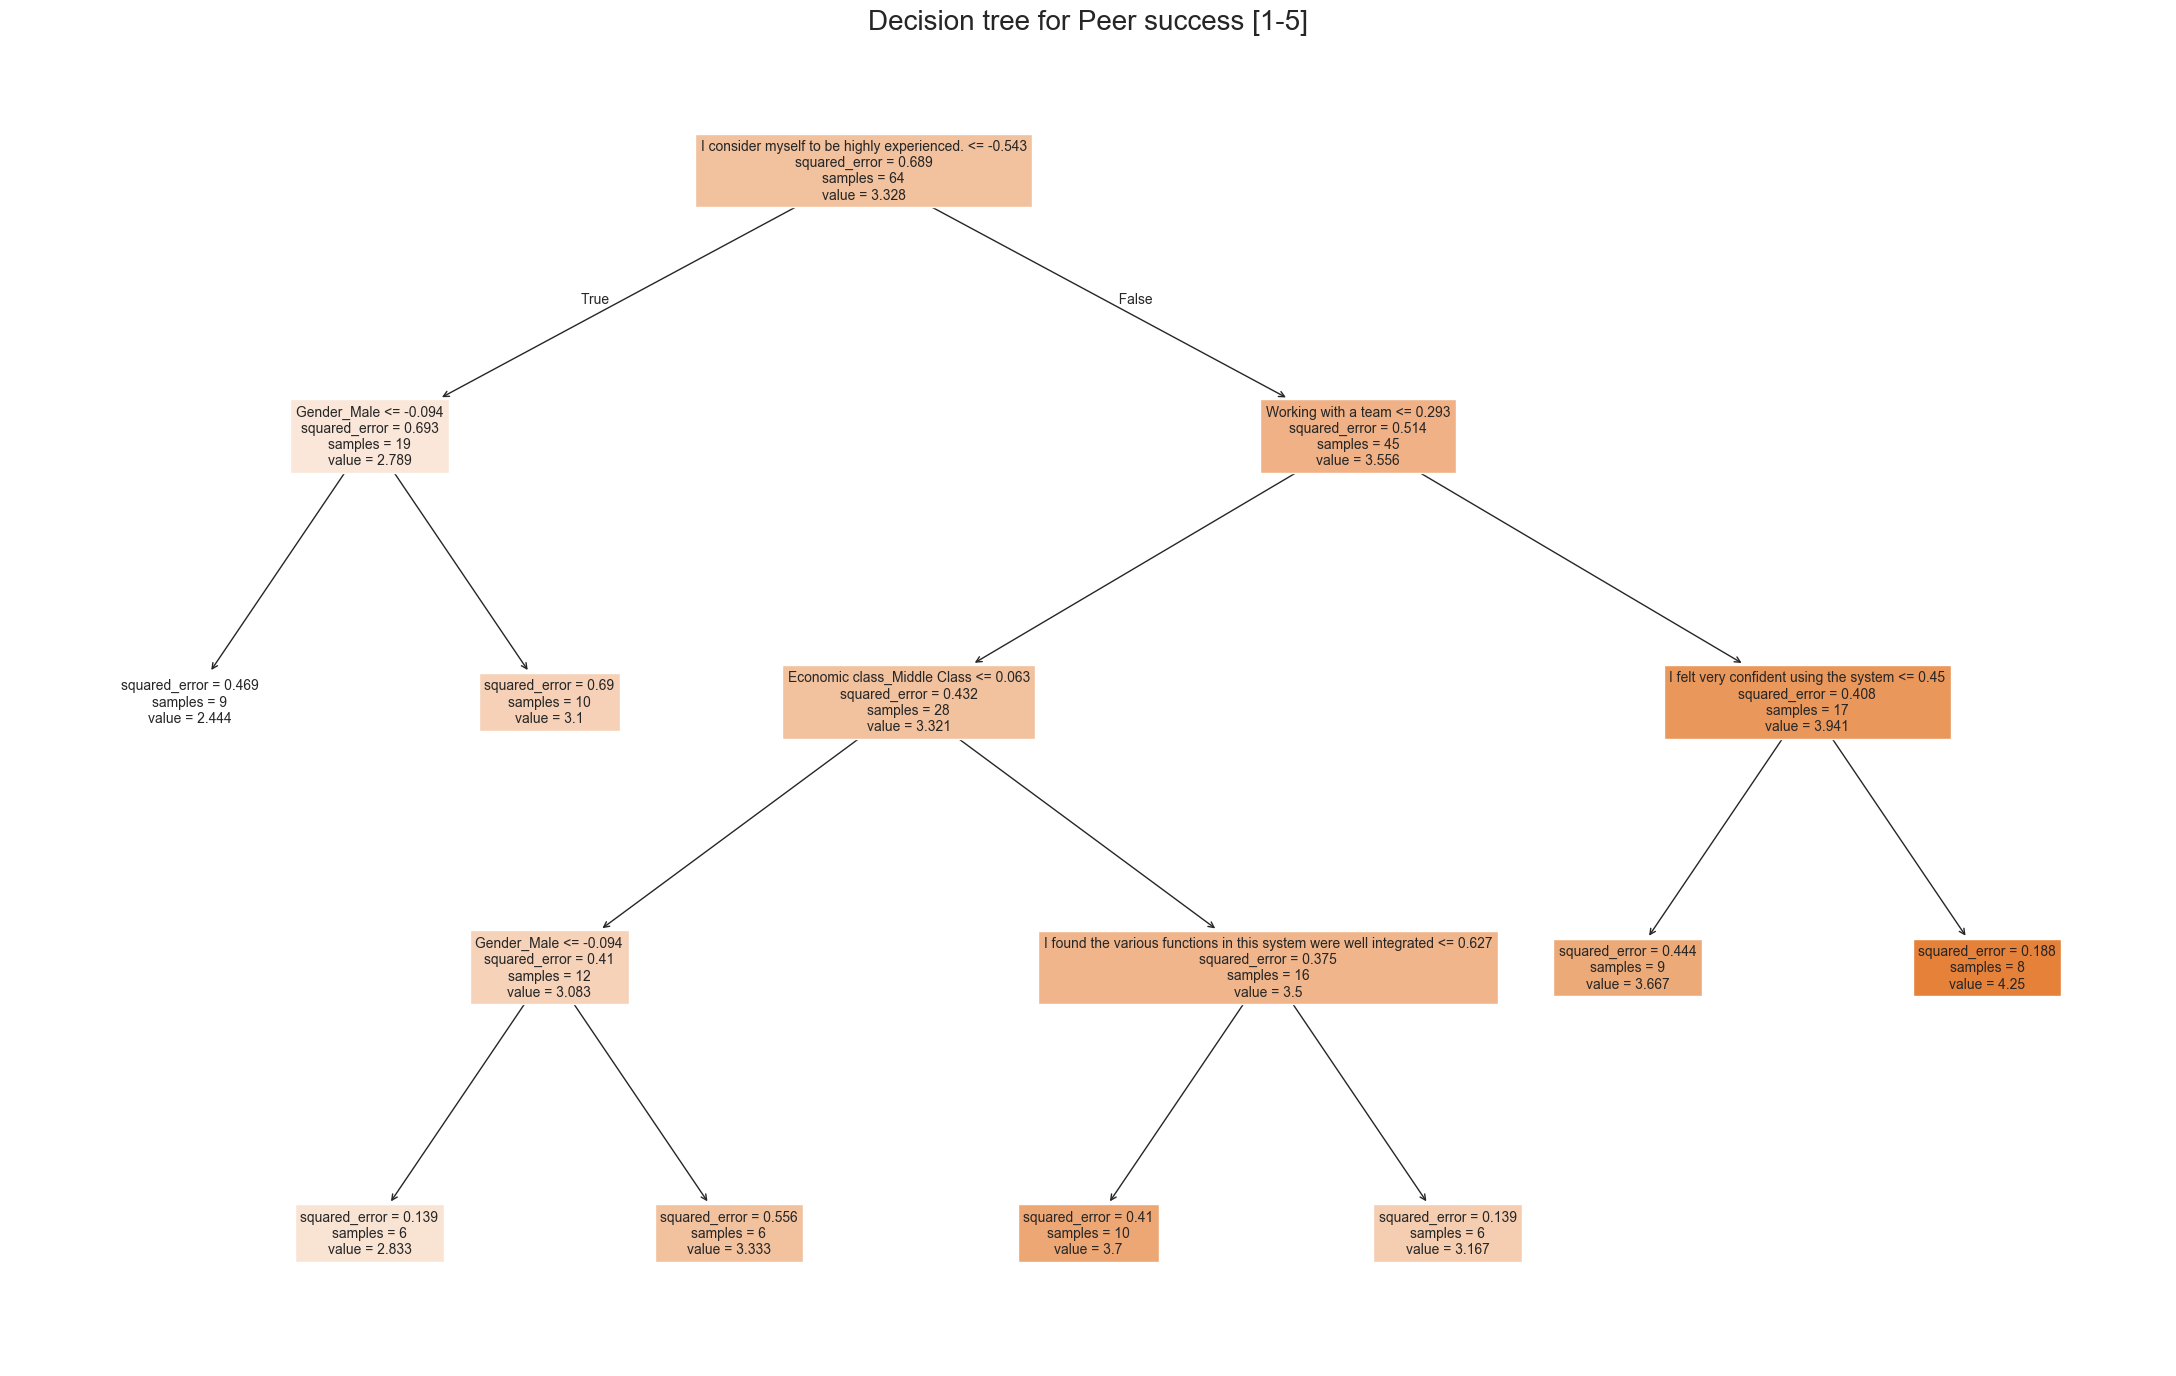

Satisfaction in SEAL trainRMSE: 0.56 testRMSE: 0.70
Depth of tree for Satisfaction in SEAL: 3


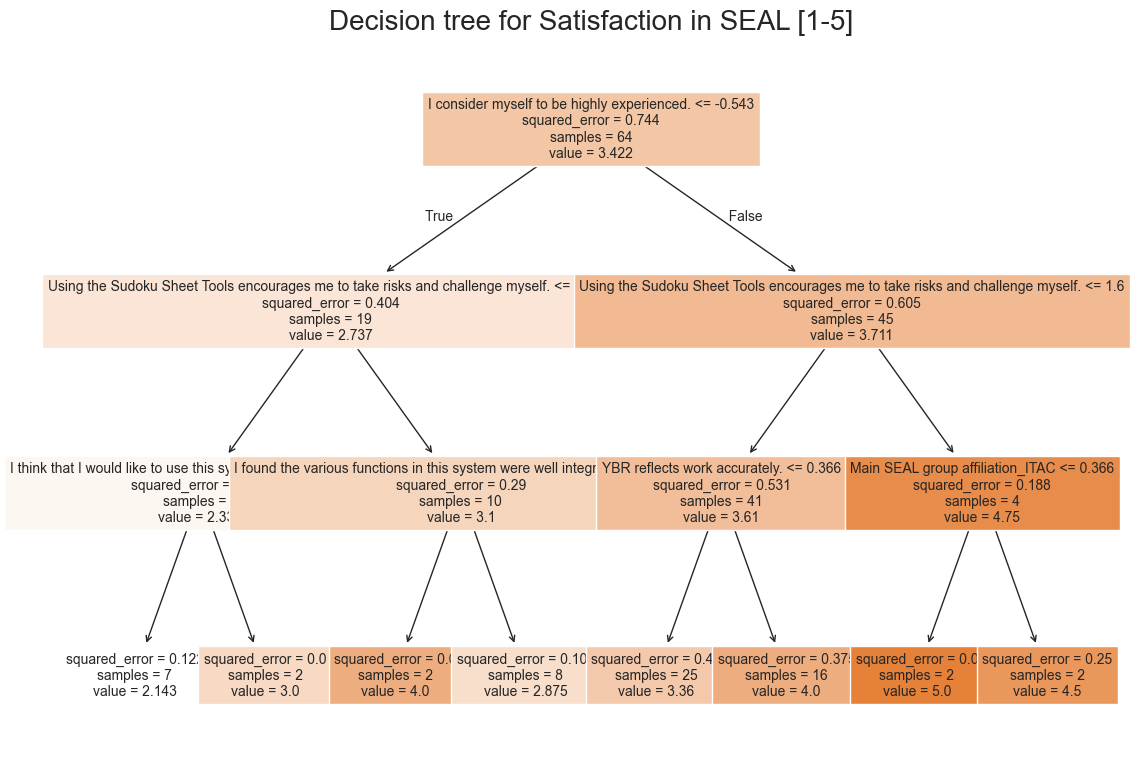

In [169]:
# decision trees
best_models, train_rmses, test_rmses, best_params = decision_tree(x_train_reduced, y_train, x_test_reduced, y_test)
tree_visualize(best_models, top_features, Y_COLS, train_rmses, test_rmses)

                                        Personal success Teammate success  \
[Introverted - Extroverted]                     0.077907         0.696202   
[Critical - Trusting]                           0.310367         0.641411   
[Spontaneous - Conscientious]                   0.934835         0.189732   
[Self-conscious - Even-tempered]                0.005366         0.932194   
[Prefer similarity - Am open to change]         0.260153         0.590123   

                                        Peer success Satisfaction in SEAL  
[Introverted - Extroverted]                 0.020601             0.116783  
[Critical - Trusting]                       0.680367             0.227498  
[Spontaneous - Conscientious]               0.869589             0.279651  
[Self-conscious - Even-tempered]             0.07188             0.036073  
[Prefer similarity - Am open to change]     0.161786             0.075113  


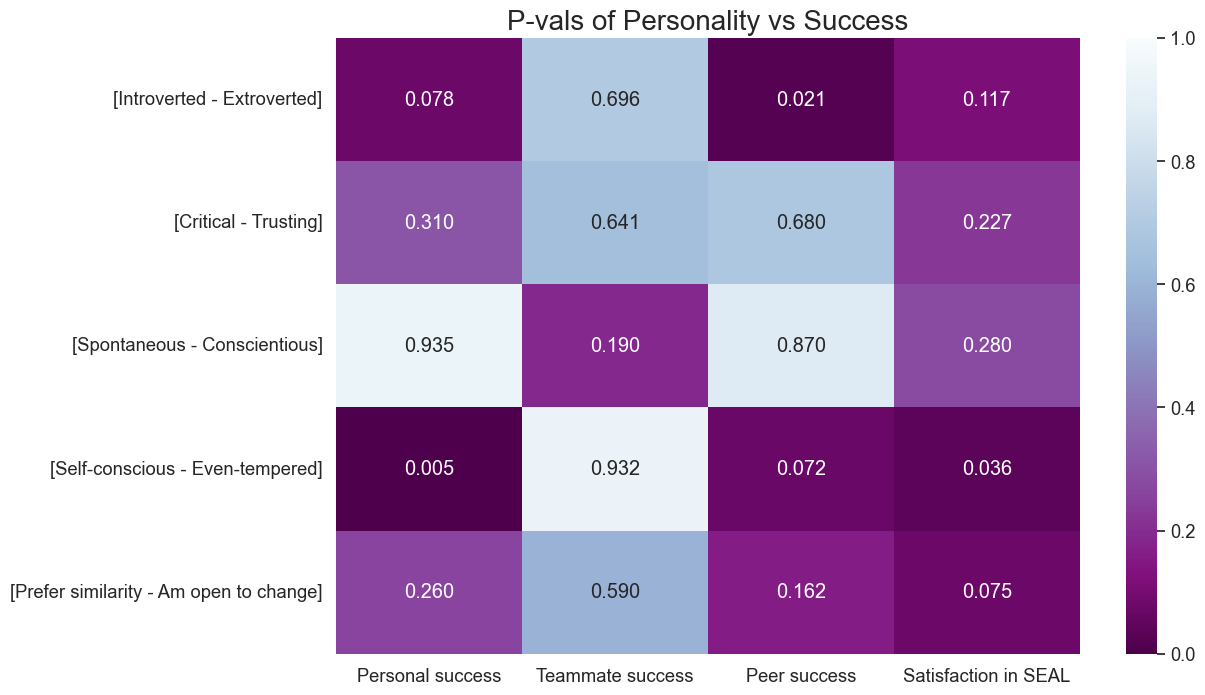

                                   Personal success Teammate success  \
Beating my competitors                      0.79713         0.115284   
Mastering the game                         0.351851         0.229419   
Earning the most points                     0.98739         0.701677   
Working with a team                        0.850332         0.334663   
Feeling immersed in the story/plot          0.21909         0.580407   
Equally motivated by int/ext               0.848819         0.655619   
Highly externally motivated                0.794543         0.392938   
Highly internally motivated                0.974037         0.163438   

                                   Peer success Satisfaction in SEAL  
Beating my competitors                 0.805407             0.613462  
Mastering the game                     0.894567             0.654474  
Earning the most points                0.296327             0.492664  
Working with a team                    0.004332             0.02975

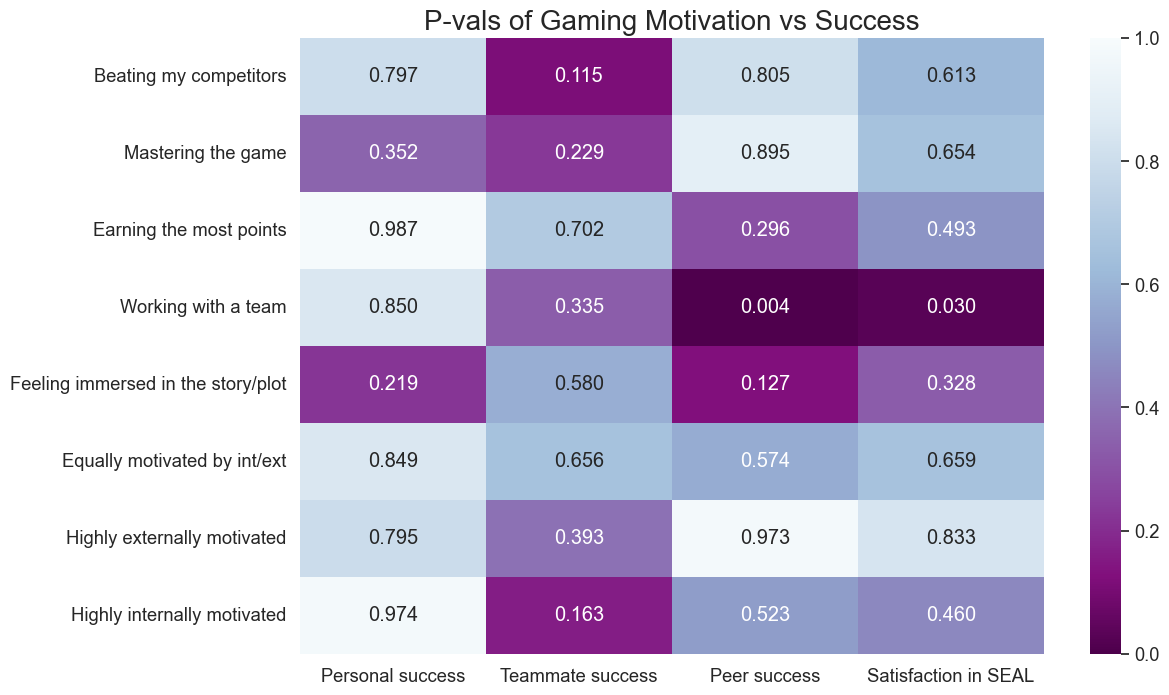

In [88]:
# stats for p-values 
# personality vs y values
from scipy.stats import pearsonr
personality_p_vals = pd.DataFrame(index=X_PERSONALITY_COLS[1:], columns=Y_COLS)

for x in X_PERSONALITY_COLS[1:]:
    for y in Y_COLS:
        _, pval = pearsonr(x_data[x], y_data[y])
        personality_p_vals.loc[x,y] = pval
print(personality_p_vals)

plt.figure(figsize=(12,8))
sns.heatmap(personality_p_vals.astype(float),
            cmap='BuPu_r', annot=True, fmt=".3f", vmin=0.0, vmax=1.0
            )
plt.title("P-vals of Personality vs Success", fontsize = 20)
plt.tight_layout
plt.show()

## gaming motivation p vals
search =  MOTIVATION_COLS + ["Internal / External game motivation"]
gaming_motivation = x_data.loc[:, x_data.columns.str.contains('|'.join(search))]
# full set gamer motivation vs y values
motivation_labels = ["Beating my competitors", "Mastering the game", "Earning the most points", "Working with a team",
                     "Feeling immersed in the story/plot", "Equally motivated by int/ext", "Highly externally motivated", "Highly internally motivated"]

motivation_pvals = pd.DataFrame(index=motivation_labels, columns=Y_COLS)
for i, x in enumerate(gaming_motivation.columns):
    for y in Y_COLS:
        _, pval = pearsonr(gaming_motivation[x], y_data[y])
        motivation_pvals.loc[motivation_labels[i],y] = pval
print(motivation_pvals)

plt.figure(figsize=(12,8))
sns.heatmap(motivation_pvals.astype(float),
            cmap='BuPu_r', annot=True, fmt=".3f", vmin=0.0, vmax=1.0
            )
plt.title("P-vals of Gaming Motivation vs Success", fontsize = 20)
plt.tight_layout
plt.show()